In [ ]:
import torch.nn as nn
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from dataloader.svdd_dataloader import CollisionLoader_audio as CollisionLoader_new
from nets.gaussianNet import GaussianSVDDModel 
%matplotlib inline
torch.manual_seed(42)
np.random.seed(42)

### Set the Configuration

In [1]:
train_audio = '/home/iot/collision_detect/new_data/audio_np/Normal_test'
train_imu = '/home/iot/collision_detect/new_data/imu_np/Normal_test'
test_audio = '/home/iot/collision_detect/new_data/audio_np/Abnormal'
test_imu = '/home/iot/collision_detect/new_data/imu_np/Abnormal'
workers = 4
feature_dim = 32
batchsize = 64
use_attention = 1

checkpoint_path = f'/home/iot/GSVDD/output/test/model_32_29_final'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

reconstruction_loss_fn = nn.SmoothL1Loss()
loss_function = nn.MSELoss()

train_data = CollisionLoader_new(train_imu,train_audio,train=True)
val_data   = CollisionLoader_new(test_imu,test_audio,train=False)
train_dataloader = DataLoader(train_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)
val_dataloader   = DataLoader(val_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)

model = GaussianSVDDModel(output_dim=feature_dim,is_train=0).to(device)
model = model.to(device)
model.load_checkpoint(checkpoint_path)
model.eval()

cuda
Model loaded from /home/iot/GSVDD/output/test/model_32_29_final.


GaussianSVDDModel(
  (audio_encoder): Conv1DFeatureExtractor(
    (conv1): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn6): BatchNorm1d(64, eps=1e-05, momentum

### Calculate the feature and loss for the anomaly data

In [2]:
reconstruction_losses_anomaly = []
svdd_losses_anomaly = []
total_z_anomaly = []
total_sample = 0
# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(val_data)):
        spec, image, audio,_,_ = val_data[sample_idx]
        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        anomaly_score, reconstructed_audio, reconstructed_imu,z= model(audio, image)
        reconstruction_loss = reconstruction_loss_fn( audio, reconstructed_audio) 
        svdd_loss = anomaly_score
        total_loss = svdd_loss + reconstruction_loss
        reconstruction_losses_anomaly.append(reconstruction_loss.item())
        svdd_losses_anomaly.append(svdd_loss.item())
        total_z_anomaly.append(z.squeeze().detach().cpu().numpy())
        total_sample+=1

# Plotting the data distribution of losses using scatter plots
mean_reconstruction_loss = sum(reconstruction_losses_anomaly) / len(reconstruction_losses_anomaly)
mean_svdd_loss = sum(svdd_losses_anomaly) / len(svdd_losses_anomaly)

### Calculate the feature and loss for the normal data

In [3]:
# Initialize lists to store individual loss values
reconstruction_losses_normal = []
svdd_losses_normal = []
total_z_normal = []
# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(train_data)):
        spec, image, audio,_,_ = train_data[sample_idx]
        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        # Forward pass through the model
        anomaly_score, reconstructed_audio, reconstructed_imu,z = model(audio, image)

        reconstruction_loss = reconstruction_loss_fn( audio, reconstructed_audio) 
        svdd_loss = anomaly_score
        total_loss = svdd_loss + reconstruction_loss
        reconstruction_losses_normal.append(reconstruction_loss.item())
        svdd_losses_normal.append(svdd_loss.item())
        total_z_normal.append(z.squeeze().detach().cpu().numpy())
        

mean_reconstruction_loss = sum(reconstruction_losses_normal) / len(reconstruction_losses_normal)
mean_svdd_loss = sum(svdd_losses_normal) / len(svdd_losses_normal)

### Plot the distribution

In [ ]:
import seaborn as sns
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.histplot(svdd_losses_normal, color='blue', label='Train', kde=False, bins=200, stat="density")
sns.histplot(svdd_losses_anomaly, color='red', label='Validation', kde=False, bins=200, stat="density")
plt.xlabel('SVDD Loss')
plt.ylabel('Density')
plt.title('SVDD Loss Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(svdd_losses_normal)), svdd_losses_normal, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(svdd_losses_anomaly)), svdd_losses_anomaly, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
plt.legend()

### Calculate the metrics

In [5]:
from deepod.metrics import ts_metrics
loss_all_svdd = svdd_losses_normal+svdd_losses_anomaly
loss_all_svdd = np.array(loss_all_svdd)
loss_all_recons = reconstruction_losses_normal+reconstruction_losses_anomaly
loss_all_recons = np.array(loss_all_recons)

labels_all = np.concatenate([np.zeros(len(svdd_losses_normal)),np.ones(len(svdd_losses_anomaly))])
loss_all = [ x +3340*y for x, y in zip(loss_all_svdd, loss_all_recons)]
eval_metrics_all = ts_metrics(labels_all, (loss_all))

print(eval_metrics_all[:-2])

(0.9695879435805422, 0.9401535928549312, 0.9234399899538932, 0.8772727272727273, 0.9747474747474747)


### Plot the PCA

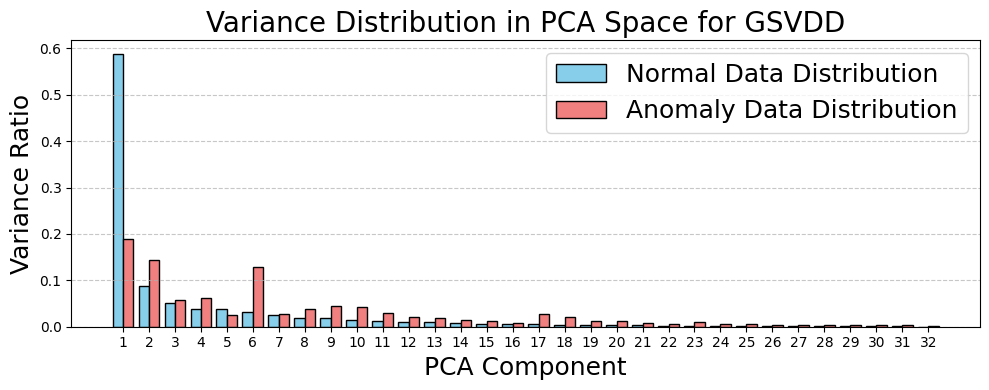

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming normal_features and anomaly_features are your input data
# Shapes: (n_normal, feature_dim) and (n_anomaly, feature_dim)
normal_features = total_z_normal
anomaly_features = total_z_anomaly

# Step 1: Fit PCA on normal features
pca = PCA(n_components=32)
pca.fit(normal_features)

# Step 2: Get the explained variance ratio for normal features
explained_variance_ratio = pca.explained_variance_ratio_

# Step 3: Transform both normal and anomaly features into the PCA space
normal_pca_projection = pca.transform(normal_features)
anomaly_pca_projection = pca.transform(anomaly_features)

# Step 4: Calculate variances for normal and anomaly projections in PCA space
normal_variances = np.var(normal_pca_projection, axis=0)
anomaly_variances = np.var(anomaly_pca_projection, axis=0)

# Step 5: Plot the explained variance and anomaly variances
plt.figure(figsize=(10, 4))

# Bar plot for normal feature explained variance
x = np.arange(1, len(explained_variance_ratio) + 1)  # Component indices
plt.bar(x - 0.2, explained_variance_ratio, width=0.4, color='skyblue', edgecolor='black', label='Normal Data Distribution')

# Bar plot for anomaly feature variances
plt.bar(x + 0.2, anomaly_variances / np.sum(anomaly_variances), width=0.4, color='lightcoral', edgecolor='black', label='Anomaly Data Distribution')

# Add labels and title
plt.title("Variance Distribution in PCA Space for GSVDD", fontsize=20)
plt.xlabel("PCA Component", fontsize=18)
plt.ylabel("Variance Ratio", fontsize=18)
plt.xticks(x)  # Ensure each component is labeled
plt.legend(fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Plot the covariance metrix

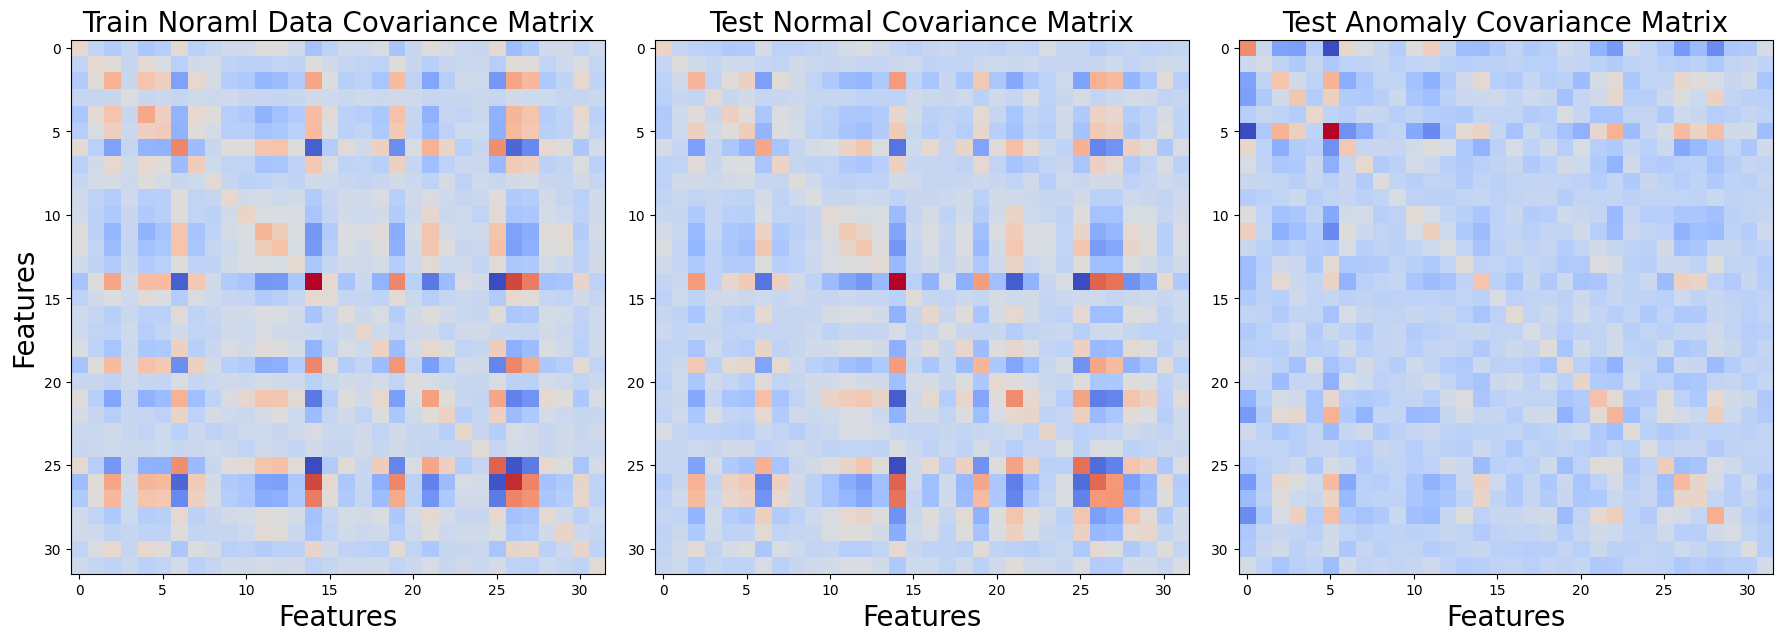

In [7]:
import numpy as np
import matplotlib.pyplot as plt

mean_vector_train = np.mean(total_z_normal, axis=0)
covariance_matrix_train = np.cov(total_z_normal, rowvar=False)
mean_vector_val = np.mean(total_z_anomaly, axis=0)
covariance_matrix_val = np.cov(total_z_anomaly, rowvar=False)
sigma_inv_matrix = (model.sigma_inv.cpu().numpy())

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(np.linalg.inv(sigma_inv_matrix), cmap='coolwarm')
axs[0].set_title("Train Noraml Data Covariance Matrix", fontsize=20)
axs[0].set_xlabel("Features", fontsize=20)
axs[0].set_ylabel("Features", fontsize=20)

axs[1].imshow(covariance_matrix_train, cmap='coolwarm')
axs[1].set_title("Test Normal Covariance Matrix", fontsize=20)
axs[1].set_xlabel("Features", fontsize=20)

axs[2].imshow(covariance_matrix_val, cmap='coolwarm')
axs[2].set_title("Test Anomaly Covariance Matrix", fontsize=20)
axs[2].set_xlabel("Features", fontsize=20)
plt.tight_layout()
plt.show()


### Calculate the accuracy for both normal and anomaly conditions

In [8]:
from utils.sample_inference import calculate_acc
calculate_acc(labels_all,loss_all,train_data,svdd_losses_normal,val_data,svdd_losses_anomaly)

The thredhold is: 3.7745398941915482
-----------------------------------
Overall Accuracy:
  Accuracy: 0.9128

Indoor Group Accuracy:
  Accuracy: 0.8894

Outdoor Group Accuracy:
  Accuracy: 0.9390
-----------------------------------
Overall Accuracy:
  Accuracy: 0.9697

mach Group Accuracy:
  Accuracy: 0.9688

coli Group Accuracy:
  Accuracy: 0.9713
-----------------------------------


### Plot the t-SNE 

In [ ]:
from utils.plotting import plot_tsne
plot_tsne(total_z_normal,total_z_anomaly)


### Draw the distribution for 2D model

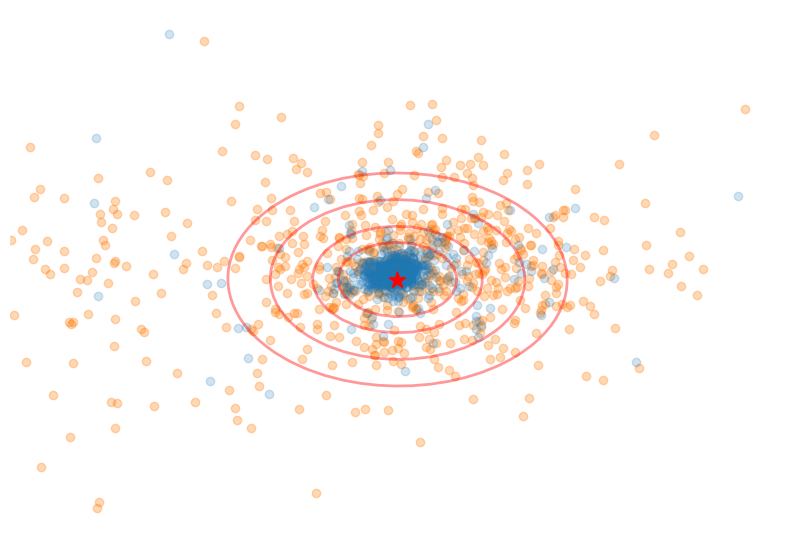

In [209]:
from utils.plotting import plot_ellipsoid
# Assuming mu, sigma_inv, X_train, and X_test are available as NumPy arrays
plot_ellipsoid(mu, sigma_inv, X_train, X_test, file_name='/home/iot/collision_detect/svdd/ploting/figures/ellipsoid_plot3.png')
